In [1]:
from pathlib import Path
from tqdm import tqdm
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.metrics import confusion_matrix, classification_report
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


### Load data and divide into train and test set:

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
train_image_dict = {}
test_image_dict = {}
val_image_dict = {}
for tumor_type in list(image_dict.keys()):
    train_image_dict[tumor_type] = image_dict[tumor_type][:120]
    val_image_dict[tumor_type] = image_dict[tumor_type][120:150]
    test_image_dict[tumor_type] = image_dict[tumor_type][150:]
print(*image_dict.keys(), sep=', ')

Astrocitoma, Carcinoma, Ependimoma, Germinoma, Glioblastoma, Meduloblastoma, Meningioma, Neurocitoma, Oligodendroglioma, Papiloma, Schwannoma, Tuberculoma, _NORMAL


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_dict, data_path, transform=None, transform_label=None):
        self.data_path = data_path
        self.image_dict = image_dict
        self.classes = list(image_dict.keys())
        self.image_class_list = [(item, key) for key, item_list in image_dict.items() for item in item_list]
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_class_list)

    def __getitem__(self, idx):
        label = self.classes.index(self.image_class_list[idx][1])
        img_path = os.path.join(self.data_path, self.image_class_list[idx][0])
        image = cv2.imread(img_path, 0)
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label

### ResNet34

#### Hyperparameters set

In [4]:
learning_rate = 3e-4
batch_size = 16
epochs = 50
n_classes = len(image_dict.keys())

#### Image augmentation

In [5]:
training_transform = transforms.Compose([transforms.ToTensor(),
                                   #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                   transforms.RandomRotation(45),
                                   transforms.RandomHorizontalFlip(p=0.5)])

#### Load dataset into Dataloaders

Feature batch shape: torch.Size([16, 1, 256, 256])
Labels batch shape: torch.Size([16])


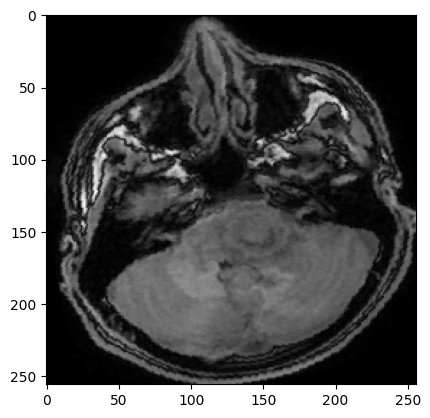

Label: 11


In [6]:
train_dataset = BrainTumorDataset(train_image_dict, data_path, transform=training_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BrainTumorDataset(test_image_dict, data_path, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = BrainTumorDataset(val_image_dict, data_path, transform=transforms.ToTensor())
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(image, cmap="gray")
plt.show()
print(f"Label: {label}")

#### Load model and modify

In [7]:
model = torchvision.models.resnet34(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#vgg19.classifier[0] = nn.Linear(in_features=512*7, out_features=4096, bias=True)
model = nn.Sequential(model, nn.Sequential(nn.ReLU(),
                                   nn.Linear(1000, n_classes),#))
                                   nn.Softmax(dim=1)))

/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

#### Training loop

In [8]:
loss_fn = nn.CrossEntropyLoss()
#params = [p for p in vgg19.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

------------ Epoch: 0 ------------
Training loss: 6.059209, total loss: 1.310995
Time elapsed: 16.118549346923828
------------ Epoch: 1 ------------
Training loss: 6.016210, total loss: 1.304974
Time elapsed: 14.572954416275024
------------ Epoch: 2 ------------
Training loss: 5.945156, total loss: 1.296091
Time elapsed: 14.682409524917603
------------ Epoch: 3 ------------
Training loss: 5.856567, total loss: 1.276801
Time elapsed: 15.03068995475769
------------ Epoch: 4 ------------
Training loss: 5.763293, total loss: 1.256261
Time elapsed: 15.197771549224854
------------ Epoch: 5 ------------
Training loss: 5.657441, total loss: 1.236859
Time elapsed: 14.823389768600464
------------ Epoch: 6 ------------
Training loss: 5.564228, total loss: 1.223285
Time elapsed: 14.05736494064331
------------ Epoch: 7 ------------
Training loss: 5.497776, total loss: 1.214130
Time elapsed: 14.354503870010376
------------ Epoch: 8 ------------
Training loss: 5.416584, total loss: 1.205005
Time elap

Text(0.5, 0, 'Epoch')

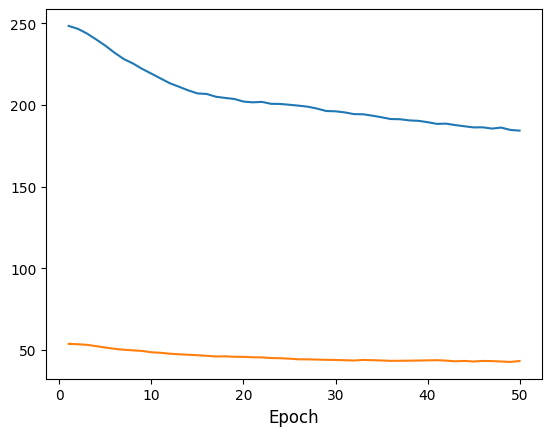

In [9]:
model.to(device)
all_loss = []
all_valid_loss = []
for epoch in range(epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    training_loss = 0
    valid_loss = 0
    start = time.time()
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        #print(torch.sum(pred[0]))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        #print(loss)
        training_loss += loss
    
    for batch, (X, y) in enumerate(val_dataloader):
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))
        
        valid_loss += loss.item()
        
    print(f"Training loss: {training_loss/41:>7f}, validation loss: {valid_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(training_loss)
    all_valid_loss.append(valid_loss)

fig = plt.figure()
plt.plot(range(1, epochs+1), all_loss)
plt.plot(range(1, epochs+1), all_valid_loss)
plt.xlabel('Epoch', fontsize=12)

#### Evaluation:

              precision    recall  f1-score   support

           0       0.69      0.48      0.56        50
           1       0.45      0.10      0.16        50
           2       0.00      1.00      0.00         0
           3       0.00      1.00      0.00         0
           4       0.34      0.24      0.28        50
           5       0.00      1.00      0.00         0
           6       0.66      0.54      0.59        50
           7       0.54      0.28      0.37        50
           8       0.26      0.12      0.16        50
           9       0.48      0.42      0.45        50
          10       0.62      0.20      0.30        50
          12       0.96      0.86      0.91        50

    accuracy                           0.36       450
   macro avg       0.42      0.52      0.32       450
weighted avg       0.56      0.36      0.42       450



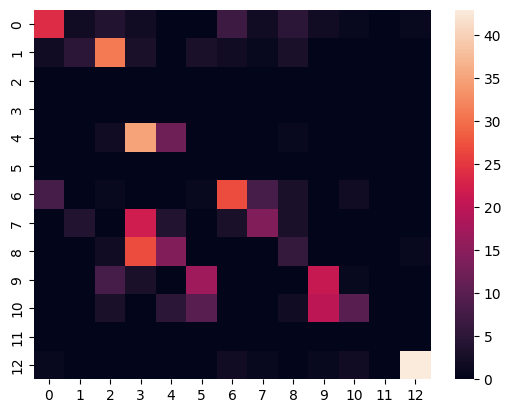

In [10]:
model.to('cpu')
predictions, labels = [], []
for batch, (X, y) in enumerate(test_dataloader):
    # Compute prediction and loss
    pred = torch.argmax(model(X), dim=1)
    #print(pred)
    predictions += pred.tolist()
    labels += y.tolist()

sns.heatmap(confusion_matrix(labels, predictions, labels=range(0, n_classes)))
print(classification_report(labels, predictions, zero_division=1))